<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Bulldozer-Price-Regression-Project/blob/master/Dog_Breed_Classification_Data_Preparation_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds


In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

It is a multi-class image classification problem. It's multi-class because we're trying to classify mutliple different breeds of dog.

We're going to follow the following TensorFlow/Deep Learning workflow:
1. Get data ready 
    * Download from Kaggle 
    * Upload to Google Drive
    * Unzip
    * Import
2. Prepare the data 
    * preprocessing
    * Preparing train, validation and test set
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model 
    * making predictions
    * comparing them with the ground truth labels
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once satisfactory results obtained).

**For preprocessing our data:** 
We're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

**For our machine learning model:** 
We're going to be using a pretrained deep learning model from TensorFlow Hub. 

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.



## Getting our workspace ready


### Import tensorflow 2.x and tensorflow_hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
print(tf.__version__)
print(hub.__version__)
print("GPU Available!" if tf.config.list_physical_devices("GPU") else "Not Available.")

2.2.0
0.8.0
GPU Available!


In [ ]:
# Other imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, Image

### To use GPU 
> goto Runtime->Change Runtime Type and select GPU  
**Remember this will reset your kernel/Runtime so you will need to reinstantiate everything**

#### Let us check how fast GPU actually is!!

In [ ]:
# some code to test speed of GPU vs CPU [taken from colab]
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.1546160070010956
GPU (s):
0.1099258659996849
GPU speedup over CPU: 28x


## Getting data ready

There are a few ways we could do this. Many of them are detailed in the [Google Colab notebook on I/O (input and output)](https://colab.research.google.com/notebooks/io.ipynb).

Because the data we're using is hosted on Kaggle, we could even use the [Kaggle API](https://www.kaggle.com/docs/api).


We can also upload to Google Drive, mount the drive to this notebook and import the file.

### Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



Following the prompts from the cell above, if everything worked, we should see a "drive" folder available under the Files tab.

This means we'll be able to access files in our Google Drive right in this notebook.

For this project, I've [downloaded the data from Kaggle](https://www.kaggle.com/c/dog-breed-identification/data) and uploaded it to my Google Drive as a .zip file under the folder "Data".

To access it, we'll have to unzip it.

**Note:** Running the cell below for the first time could take a while (a couple of minutes is normal). After you've run it once and got the data in your Google Drive, you don't need to run it again.



### Unzip data folder in drive

In [ ]:
# Use the '-d' parameter as the destination for where the files should go
#!unzip "drive/My Drive/Dog-Breed-Classification-Deep-Learning/dog-breed-identification.zip" -d "drive/My Drive/Dog-Breed-Classification-Deep-Learning/"

Once the files have been unzipped to your Google Drive, you don't have to run the cell above anymore.


### Accessing the data

Now the data files we're working with are available on our Google Drive, we can start to check it out.

Let's start with `labels.csv` which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [ ]:
import pandas as pd
labels_csv = pd.read_csv('drive/My Drive/Dog-Breed-Classification-Deep-Learning/labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,1d90999b84c12bce58f0157fbbd530cb,scottish_deerhound
freq,1,126


In [ ]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


Let us visualize how many images we have of each class by making a bar plot.

In [ ]:
labels_csv.dtypes

id       object
breed    object
dtype: object

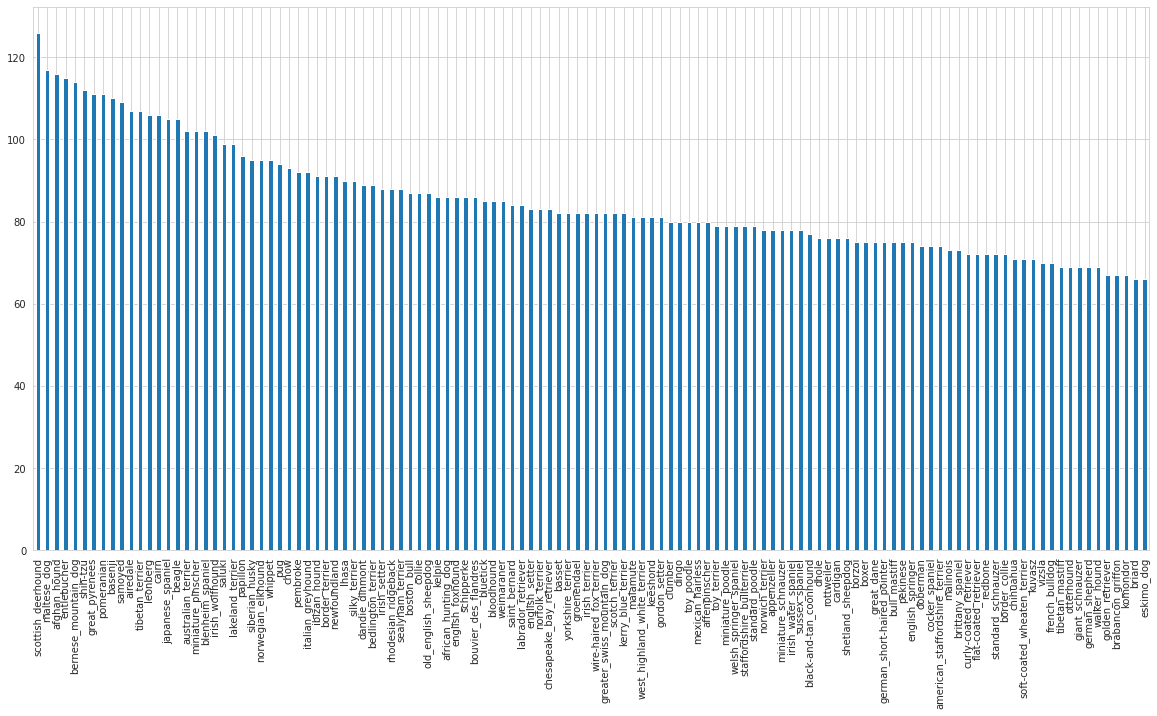

In [ ]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));

In [ ]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

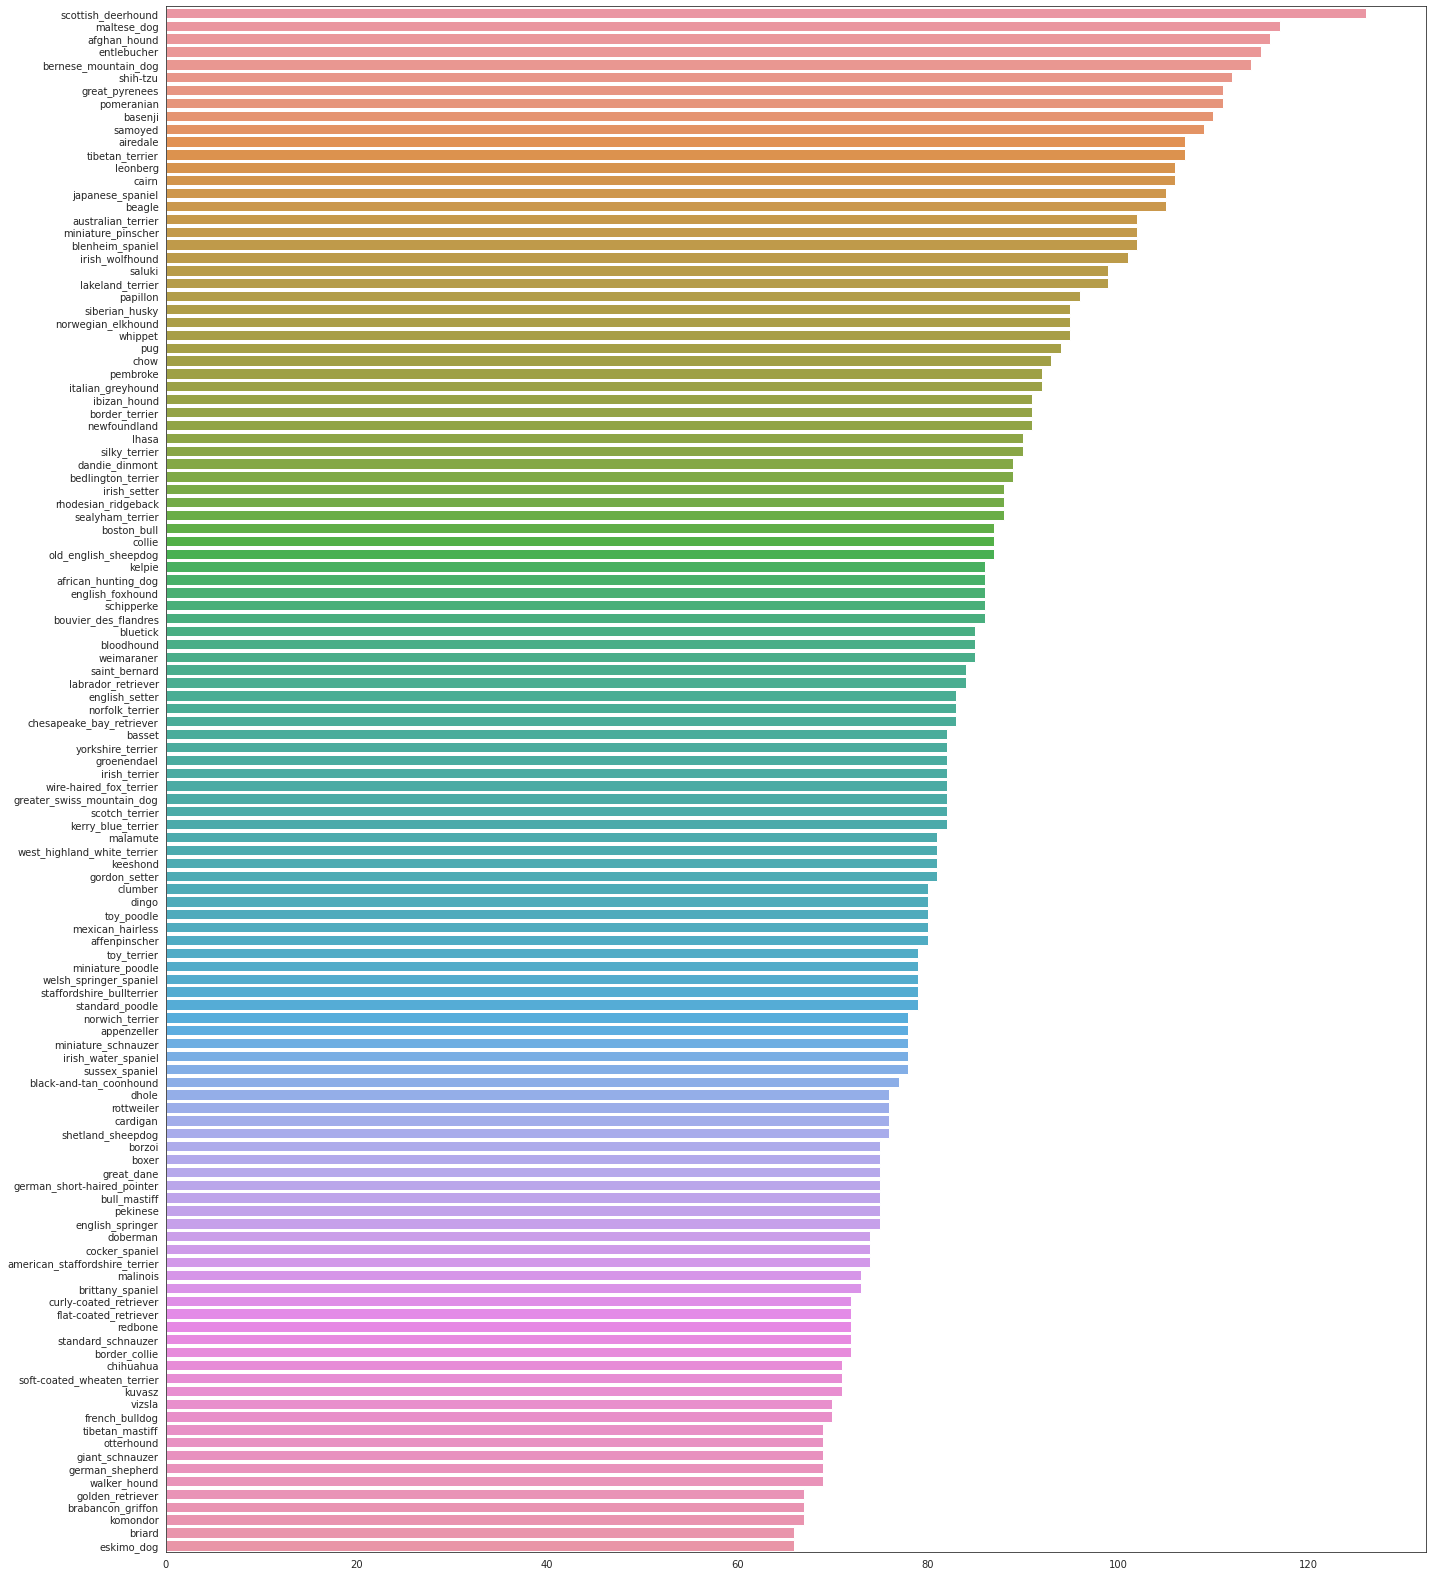

In [ ]:
sns.set_style('white')
plt.figure(figsize=(20,22))
sns.barplot(y= labels_csv["breed"].value_counts().index,x = labels_csv["breed"].value_counts().values,orient='h')
plt.tight_layout()
# plt.set_xticklabels(rotation=90)
# plt.xticks(rotation='vertical');

# sns.lineplot(y = np.mean(labels_csv['breed'].value_counts().values), x=labels_csv["breed"].value_counts().index);

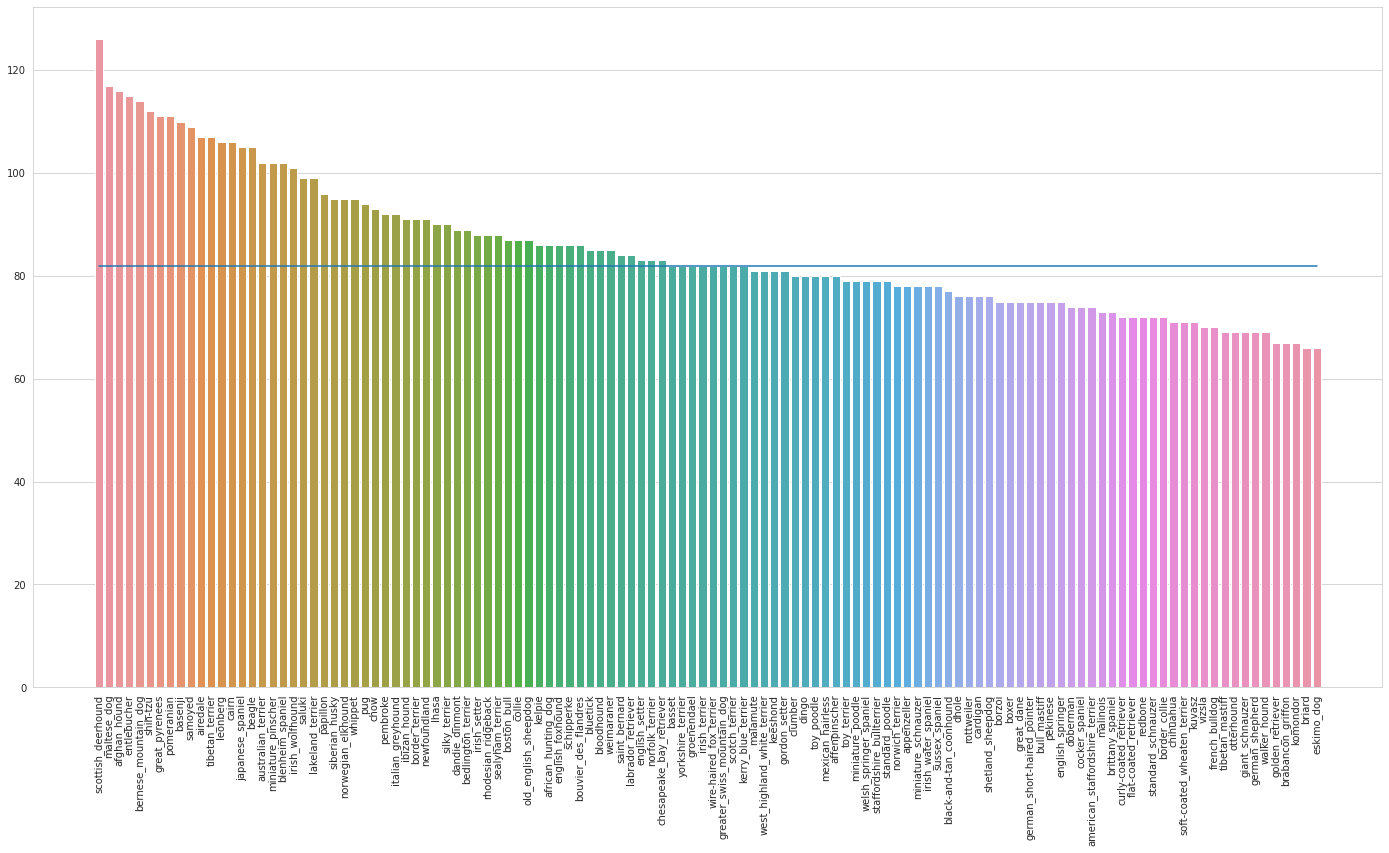

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,10))
sns.barplot(x= labels_csv["breed"].value_counts().index,y = labels_csv["breed"].value_counts().values)
plt.tight_layout()
# plt.set_xticklabels(rotation=90)
plt.xticks(rotation='vertical');
sns.lineplot(y = np.median(labels_csv['breed'].value_counts().values), x=labels_csv["breed"].value_counts().index);

In [ ]:
np.mean(labels_csv['breed'].value_counts().values),np.median(labels_csv['breed'].value_counts().values)

(85.18333333333334, 82.0)

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.


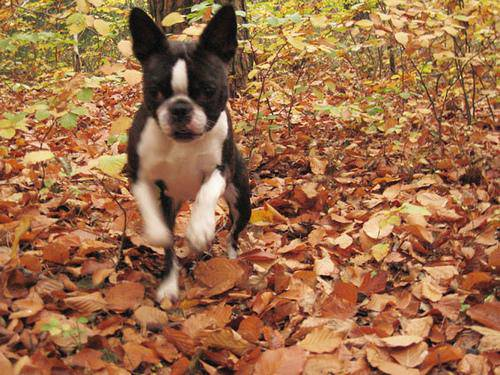

In [ ]:
from IPython.display import display, Image
Image('drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

Yupp... That's a cute little dog!!  

Now that we have visualized our data and know the average distribution, let us convert into a format that can be used for training out models

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_csv`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [ ]:
filenames = ['drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/' + fname + '.jpg' for fname in labels_csv['id']]
filenames[:5]

['drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
filenames[5]

'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/002211c81b498ef88e1b40b9abf84e1d.jpg'

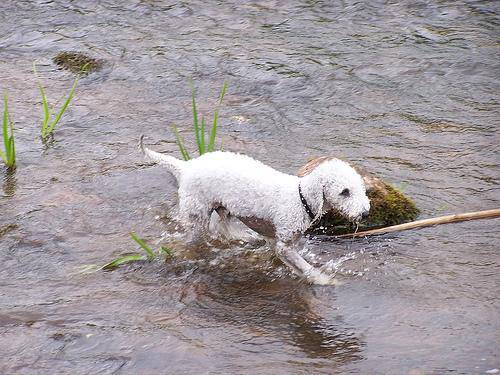

In [ ]:
Image('drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg')
Image(filenames[5])

Now we've got a list of all the filenames from the ID column of `labels_csv`, we can compare it to the number of files in our training data directory to see if they line up.

If they do, great. If not, there may have been an issue when unzipping the data (what we did above), to fix this, you might have to unzip the data again. Be careful not to let your Colab notebook disconnect whilst unzipping.

In [ ]:
len(filenames)

10222

In [ ]:
import os
if len(os.listdir('drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/'))==len(filenames):
  print('Number of files in google drive train folder and in our file names match.')
else:
  print('number of files donot match.')


Number of files in google drive train folder and in our file names match.


Yesss!!! So the number of files match.

In [ ]:
labels = labels_csv['breed'].to_numpy()

In [ ]:
labels[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

Now let's compare the length of labels to the length of filenames to check if they are same.

In [ ]:
if len(labels)==len(filenames):
  print('same length.')
else:
  print('Length not same.')

same length.


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers. 

To begin with, we'll find all of the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

Below I have demonstrated 2 ways to get the list of unique labels  
1) saved to unique_labels  [Using `np.array(labels_csv['breed'].value_counts().index)`]  
2) saved to unique_breeds [Using `np.unique(labels)`]

In [ ]:
unique_labels = np.array(labels_csv['breed'].value_counts().index)

In [ ]:
len(unique_labels)

120

In [ ]:

unique_labels[:5]

array(['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher',
       'bernese_mountain_dog'], dtype=object)

In [ ]:
unique_breeds = np.unique(labels)
unique_breeds[:5]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier'], dtype=object)

In [ ]:
len(unique_breeds)

120

For now let's work using `unique_breeds`

Now that we have an array of unique labels, we can use `unique_breeds` to help turn our `labels` array into an array of booleans .we can label of each image with `unique_breed` array and get a boolean array for that label that is `True` at place where label value is equal to value in `unique_breed` array else `False`. This is for making a `One Hot Array`

In [ ]:
# First try converting one label to a boolean array
boolean = (labels[0]==unique_breeds)
boolean

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Similarily we convert our full labels array to a boolean form
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)==len(filenames)

True

Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single dog breed name such as `boston_bull` into a one-hot array. 

Let's see an example.

In [ ]:
# sample conversion to numeric form
print(labels[0])
print(labels[0]==unique_breeds)
print(np.where(labels[0]==unique_breeds)[0][0])
print(boolean_labels[0].argmax())
print((labels[0]==unique_breeds).astype(int))

boston_bull
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


Wonderful! Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

### Creating our own validation set

Since this dataset from Kaggle doesn't come with a validation set, we'll need to make one.

We could use Scikit-Learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function or we could simply make manual splits of the data.

For accessibility later, let's save our filenames variable to `X` (data) and our labels to `y`.

In [ ]:
X = filenames.copy()
y = boolean_labels.copy()

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
X[:5]

['drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
y[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Since we're working with 10,000+ images, it's a good idea to work with a portion of them to make sure things are working before training on them all.

This is because computing with 10,000+ images could take a fairly long time. And our goal when working through machine learning projects is to reduce the time between experiments.

Let's start experimenting with 1000 and increase it as we need.

In [ ]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

use `train_test_split` to split data into train and validation set.  
We will use a 8/2 split for our training and validation data.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:5], y_train[:2]

(['drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,

In [ ]:
X_val[:5],y_val[:2]

(['drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/0ca9280205bd68d201e1d708db3f209d.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/12405b2e93417d81f5308769c4e184c7.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/1242da788ce85d4311e1cc9922a0a809.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/1015e4eba660def32e7e52b89fe3a9c6.jpg',
  'drive/My Drive/Dog-Breed-Classification-Deep-Learning/train/09d5ac8026b8a7f7d1acae244765fe24.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,

## Preprocessing

### Preprocessing images (turning images into Tensors)

Our labels are in numeric format but our images are still just file paths.

Since we're using TensorFlow, our data has to be in the form of Tensors.

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays, a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Takes an image filename as input.
2. Uses TensorFlow to read the file and save it to a variable, `image`.
3. Turn our `image` (a jpeg file) into Tensors.
4. Resize the `image` to be of shape (224, 224).
5. Return the modified `image`.

A good place to read about this type of function is the [TensorFlow documentation on loading images](https://www.tensorflow.org/tutorials/load_data/images). 

We use (224,224,3), which is (height, width, channels), because this is the size of input that the model we are going to use takes.




In [ ]:
image = plt.imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

Now, we can convert these images into tensor using `tf.constant`

In [ ]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now, let's build a function that combines all our preprocessing steps

In [ ]:
IMG_SIZE = 224
def process_image(image_path):
  """
  Takes image path as input and turns it into a tensor.

  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image
  

### Creating data batches

Wonderful. Now we've got a function to convert our images into Tensors, we'll now build one to turn our data into batches (more specifically, a TensorFlow [`BatchDataset`](https://www.tensorflow.org/guide/data#batching_dataset_elements)).

What's a batch?

A batch (also called mini-batch) is a small portion of your data, say 32 (32 is generally the default batch size) images and their labels. In deep learning, instead of finding patterns in an entire dataset at the same time, you often find them one batch at a time.

Let's say you're dealing with 10,000+ images (which we are). Together, these files may take up more memory than your GPU has. Trying to compute on them all would result in an error.

Instead, it's more efficient to create smaller batches of your data and compute on one batch at a time.



TensorFlow is very efficient when your data is in batches of (image, label) Tensors. So we'll build a function to do create those first. We'll take advantage of of `process_image` function at the same time.

In [ ]:
def tuple_image_label (image_path, label):
  """
  Processes image at image_path and returns processed image and label as a tuple.
  """
  # Process image
  image = process_image(image_path)
  return (image, label)


Now we've got a simple function to turn our image file path names and their associated labels into tuples (we can turn these into Tensors next), we'll create a function to make data batches.

Since we need to create 3 different sets: Train, valid, test and there is a difference in how training, validation and testing data needs to be processed to convert data to batches. So, this function will have 3 sections in order to address requirements of each set.

We'll set a default batch size of 32 because [according to Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?s=20) (one of the OG's of deep learning), friends don't let friends train with batch sizes over 32.

In [ ]:
BATCH_SIZE=32
def form_data_batches(X, y=None,batch_size=BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If it is a test set we won't have y labels
  if test_data:
    print("Creating testing set...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) #only file names
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # Validation set doesnot require shuffling
  elif valid_data:
    print("Creating Validation set...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # tuple of filenames and labels
    data_batch = data.map(tuple_image_label).batch(BATCH_SIZE)
    return data_batch

  #test data needs to be shuffled
  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(tuple_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data = form_data_batches(X_train, y_train)
val_data = form_data_batches(X_val,y_val, valid_data=True)

Creating training data batches...
Creating Validation set...


In [ ]:
train_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [ ]:
val_data.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

Finally... We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.


### Visualizing data batches

Now that we have data in form of tensor BatchDataset, let's visualize the batches and see how to access them. This will also help us understand what is going on behind the scenes.

In [ ]:
def show_25_images(images, labels):
  """
  Takes a batch of data as input and plots the first 25 images in the batch along with labels
  """
  # imitialize a matplotlib figure
  plt.figure(figsize=(10,10))
  # run a loop to plot 25 images
  for i in range(25):
    # divide plot into 25 (5 X 5) subplots and select (i+1)th subplot
    plt.subplot(5,5,i+1)
    # plot the current image on the (i+1)th subplot
    plt.imshow(images[i])
    # Set the image title as the breed it belongs to
    plt.title(unique_breeds[labels[i].argmax()])
    # turn axis off to prevnt crowding
    plt.axis('off')
    # Decongest the plot
    plt.tight_layout()


To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we need to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

In [ ]:
train_batch_images, train_batch_labels = next(train_data.as_numpy_iterator())

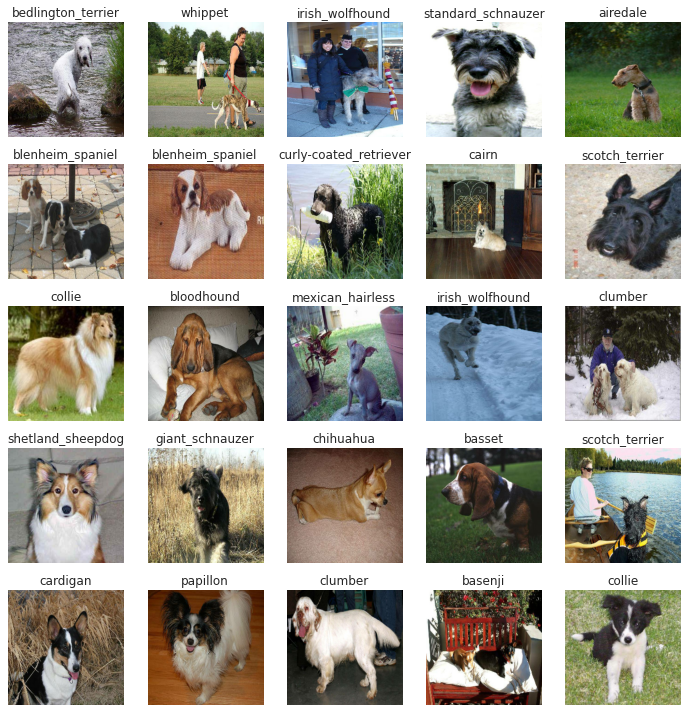

In [ ]:
show_25_images(train_batch_images, train_batch_labels)

In [ ]:
val_batch_images, val_batch_labels = next(val_data.as_numpy_iterator())

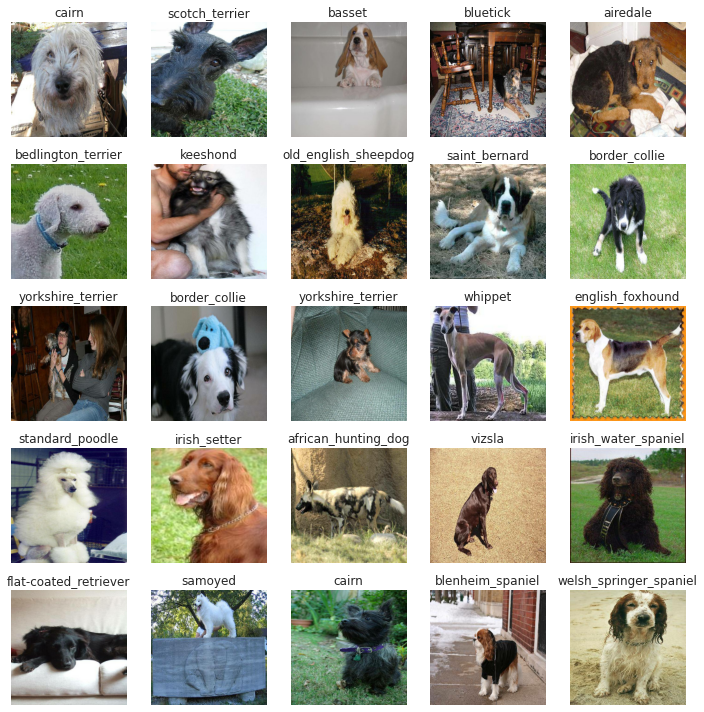

In [ ]:
show_25_images(val_batch_images, val_batch_labels)

While running the above cells and observing the images we notice that the training images are different each time but the validation images are always the same.  
This is because we shuffled the training data and not the validation data.

# Creating and training a model

In this Project we will be using transfer learning for making our classifications.  

Using a pretrained machine learning model is often referred to as **transfer learning**.  

We'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).  

TensorFlow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.  



#### Why use a pretrained model?

Building a machine learning model and training it on lots from scratch can be expensive and time consuming.

Transfer learning helps eliviate some of these by taking what another model has learned and using that information with your own problem.

#### How do we choose a model?

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub page by our problem domain (image)](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent). 

We start by choosing the image problem domain, and then can filter it down by subdomains, in our case, [image classification](https://tfhub.dev/s?module-type=image-classification).

Doing this gives a list of different pretrained models we can apply to our task.

Clicking on one gives us information about the model as well as instructions for using it.

For example, clicking on the [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model, tells us this model takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.

Let's try it out.

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

These things will be standard practice with whatever machine learning model you use. And because we're using TensorFlow, everything will be in the form of Tensors.


In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"